In [27]:
from PIL import Image
from cairosvg import svg2png
from pathlib import Path
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

In [2]:
def make_repmap(floor: str = "A", num: int = 1, has_shared_br: bool = False):
    replace_map = {}

    floor = f"{floor}{str(num)}".upper()

    if not has_shared_br:
        replace_map = {
            "floor": floor,
            "fl1": f"{floor}36",
            "fl2": f"{floor}34",
            "fl3": f"{floor}32",
            "fl4": f"{floor}30",
            "fr1": f"{floor}04",
            "fr2": f"{floor}06",
            "fr3": f"{floor}08",
            "fr4": f"{floor}10",
            "sl1": f"{floor}28",
            "sl2": f"{floor}26",
            "sl3": f"{floor}24",
            "sr1": f"{floor}12",
            "sr2": f"{floor}14",
            "sr3": f"{floor}16",
            "sr4": f"{floor}18",
        }
    else:
        replace_map = {
            "floor": floor,
            "fl1": f"{floor}34",
            "fl2": f"{floor}32",
            "fl3": f"{floor}30",
            "fl4": f"{floor}28",
            "fr1": f"{floor}04",
            "fr2": f"{floor}06",
            "fr3": f"{floor}08",
            "fr4": f"{floor}10",
            "sl1": f"{floor}24",
            "sl2": f"{floor}22",
            "sl3": f"{floor}20",
            "sr1": f"{floor}12",
            "sr2": f"{floor}14",
            "sr3": f"{floor}16",
            "sr4": "Fürdő",
        }

    return replace_map

In [10]:
def extract_data(data_file: str = "example.csv", value_key: str = "signal_dbm") -> list[tuple[int, int, int]]:
    raw_data = pd.read_csv(data_file)
    data = []

    for _, row in raw_data.iterrows():
        data.append((int(row["position_x"]), int(row["position_y"]), int(row["position_in_room"]), int(row[value_key])))
    
    return data

In [24]:
def make_image(
    replace_map: dict[str, str],
    template_path: str = "floor_template.svg",
):
    template = Path(template_path).read_text()

    for key, value in replace_map.items():
        template = template.replace(f"{{{key}}}", value)

    image = io.BytesIO()
    svg2png(bytestring=template.encode("utf-8"), write_to=image)
    image.seek(0)

    return image

In [34]:
def produce_image(
    base_image: io.BytesIO,
    overlay_alpha: float = 0.5,
    bboxes: dict[tuple[int, int], tuple[int, int, int, int]] = {},
    data: list[tuple[int, int, int]] = [],
    value_name: str = "",
    value_ext: str = "",
    vmin: float | None = None,
    vmax: float | None = None,
    out: str = "plot.png",
):

    img = Image.open(base_image).convert("RGBA")
    W, H = img.size

    overlay = np.zeros((H, W, 4), dtype=np.uint8)

    vals = np.array([v for *_, v in data], dtype=float)
    vmin = vals.min() if vmin is None else vmin
    vmax = vals.max() if vmax is None else vmax
    if vmin == vmax:
        vmin -= 1.0

    norm = Normalize(vmin=vmin, vmax=vmax)

    cmap = LinearSegmentedColormap.from_list("rg", ["r", "y", "g"], N=256)

    fig, ax = plt.subplots(figsize=(12, 6))

    room_values = defaultdict(lambda: [None, None, None])
    for x, y, pir, value in data:
        if pir not in (1, 2, 3):
            print(f"Warning: pir={pir} out of range")
            continue
        room_values[(x, y)][pir - 1] = value

    for (x, y), thirds in room_values.items():
        if (x, y) not in bboxes:
            print(f"({x},{y}) is out-of-bounds")
            continue

        left, top, right, bottom = bboxes[(x, y)]
        height = bottom - top

        values = np.array(thirds, dtype=float)

        for i in range(len(values)):
            if np.isnan(values[i]) or values[i] is None:
                if i > 0 and values[i - 1] is not None:
                    values[i] = values[i - 1]
                elif i < 2 and values[i + 1] is not None:
                    values[i] = values[i + 1]
                else:
                    values[i] = vmin

        if y == 1:
            values = values[::-1]

        y_pixels = np.linspace(top, bottom, height)
        thirds_y = np.linspace(top, bottom, len(values))
        interp_values = np.interp(y_pixels, thirds_y, values)

        for i, yy in enumerate(range(top, bottom)):
            r, g, b, _ = cmap(norm(interp_values[i]))
            overlay[yy, left:right, :] = (
                int(round(255 * r)),
                int(round(255 * g)),
                int(round(255 * b)),
                int(round(overlay_alpha * 255)),
            )

        avg_val = np.mean(values)
        cx = (left + right) / 2
        cy = bottom + 20
        ax.text(
            cx,
            cy,
            f"{avg_val:.1f} {value_ext}",
            ha="center",
            va="top",
            color="black",
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="none", alpha=0.6, edgecolor="none", pad=1),
        )

    ax.imshow(img)
    ax.imshow(overlay)
    ax.axis("off")

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.07, pad=-0.05, location="bottom")
    cbar.set_label(value_name)

    plt.tight_layout()

    plt.savefig(out)

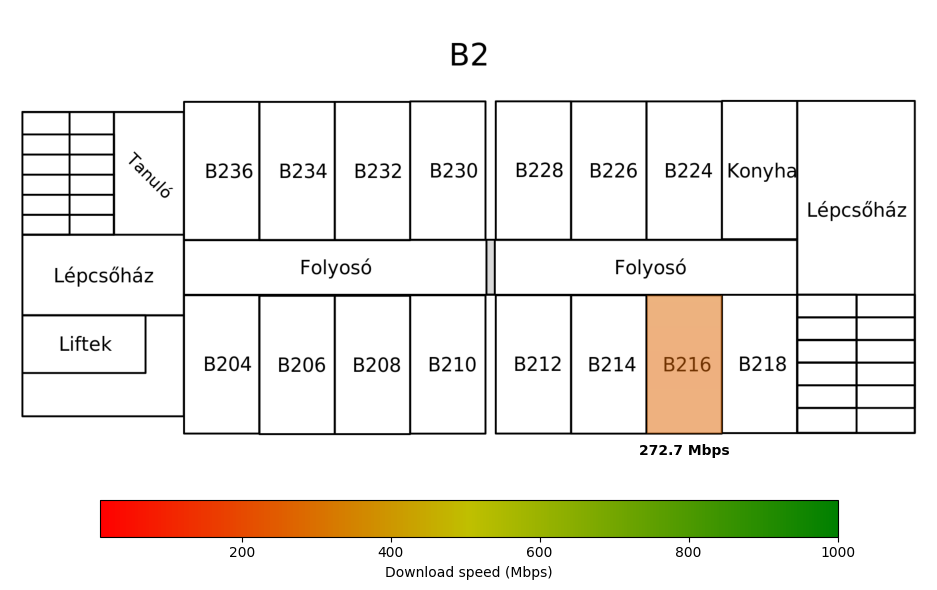

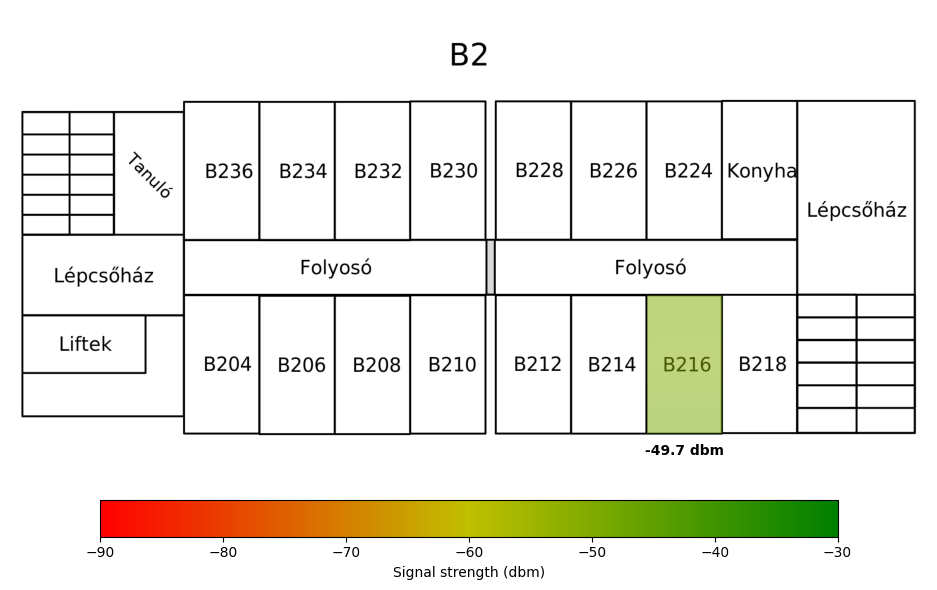

In [35]:
in_file: str = "docker_test.csv"
out_file: str = "docker_test_download.png"

value_key: str = "download"  # "signal_dbm"
value_name: str = "Download speed (Mbps)"  # "Signal strength (dbm)"
value_ext: str = "Mbps"  # "dbm"

replace_map = make_repmap("B", num=2, has_shared_br=False)
image = make_image(replace_map=replace_map)

bboxes = {
    (0, 0): (364, 194, 522, 482),
    (1, 0): (522, 194, 680, 482),
    (2, 0): (680, 194, 838, 482),
    (3, 0): (838, 194, 996, 482),
    (4, 0): (1016, 194, 1174, 482),
    (5, 0): (1174, 194, 1332, 482),
    (6, 0): (1332, 194, 1490, 482),
    (7, 0): (1490, 194, 1648, 482),
    (0, 1): (364, 598, 522, 887),
    (1, 1): (522, 598, 680, 887),
    (2, 1): (680, 598, 838, 887),
    (3, 1): (838, 598, 996, 887),
    (4, 1): (1016, 598, 1174, 887),
    (5, 1): (1174, 598, 1332, 887),
    (6, 1): (1332, 598, 1490, 887),
    (7, 1): (1490, 598, 1648, 887),
}

data = extract_data(in_file, value_key=value_key)


produce_image(
    base_image=image,
    data=data,
    bboxes=bboxes,
    value_name=value_name,
    value_ext=value_ext,
    vmin=10,
    vmax=1000,
    out=out_file,
)

out_file: str = "docker_test_signal.png"

value_key: str = "signal_dbm"
value_name: str = "Signal strength (dbm)"
value_ext: str = "dbm"

data = extract_data(in_file, value_key=value_key)

produce_image(
    base_image=image,
    data=data,
    bboxes=bboxes,
    value_name=value_name,
    value_ext=value_ext,
    vmin=-90,
    vmax=-30,
    out=out_file,
)